# Setting up

In [1]:
# Standard library imports
import gc
import itertools
import json
import os
import pickle
import pprint
import shutil
import time
import math
from collections import defaultdict
from itertools import combinations

# Third-party library imports for data handling and numerical operations
import networkx as nx
import numpy as np
import pandas as pd

# Machine learning and computer vision libraries
import torch
import cv2

# 3D data processing and visualization libraries
import open3d as o3d
import open3d.visualization.rendering as rendering
import laspy

# Scientific computing and spatial analysis
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt

# Application or project-specific modules
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def sam_masks(anns):
    """
    Generates and displays color-masked images for segmentation data provided in the annotations on a Matplotlib axes.
    Each mask is semi-transparent, allowing for visual overlay on other images plotted on the same axes.
    This function is ideal for visual inspection and presentation of multiple segmentation masks.

    Parameters:
    - anns (list of dicts): A list of annotation dictionaries, as returned by SAM. Each dictionary must contain:
      - 'area': The area of the segment (used for sorting).
      - 'segmentation': A 2D numpy array representing the binary mask of the segment.

    Returns:
    - c_mask (list of numpy arrays): A list of RGB images where each image corresponds to a color-masked version of a segmentation.
      Each element is a 3D numpy array (height, width, RGB channels). Returns None if the input list is empty.
    """    
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))
        c_mask.append(img)
    return c_mask

# Class to represent segment in 2D
class Segment2D:
    def __init__(self, area, bbox, crop_box, point_coords, predicted_iou, stability_score, segmentation):
        self.area = area
        self.bbox = bbox
        self.crop_box = crop_box
        self.point_coords = point_coords
        self.predicted_iou = predicted_iou
        self.stability_score = stability_score
        self.segmentation = segmentation

# For additional projections
def get_rotated_projection_with_mapping_yx(points, colors, angle_rad):
    # Define rotation matrix for a given angle around the Y axis
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_angle, 0, -sin_angle],
        [0, 1, 0],
        [sin_angle, 0, cos_angle]
    ])
    
    # Apply rotation
    rotated_points = np.dot(points, rotation_matrix.T)

    # Project onto Y-X' plane
    proj_points = rotated_points[:, [1, 0]]  # Using Y and X' for projection
    min_proj = np.min(proj_points, axis=0)
    max_proj = np.max(proj_points, axis=0)
    
    # Determine dimensions and initialize image and mapping for Y-X' projection
    dimensions = np.ceil(max_proj - min_proj).astype(int) + 1
    image = np.zeros((dimensions[0], dimensions[1], 3), dtype=np.uint8)
    mapping = np.full((dimensions[0], dimensions[1]), -1, dtype=int)
    
    # Convert points to indices and map colors and indices
    for i, (y, x_prime) in enumerate(proj_points):
        x_idx = int(x_prime - min_proj[1])
        y_idx = int(y - min_proj[0])
        # Update the image and mapping
        image[y_idx, x_idx] = (colors[i] * 255).astype(np.uint8)
        mapping[y_idx, x_idx] = i  # Store the index of the point
    
    return image, mapping

# For additional projections
def get_rotated_projection_with_mapping_yz(points, colors, angle_rad, direction):
    # Define rotation matrix for a given angle around the Y axis
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_angle, 0, -sin_angle],
        [0, 1, 0],
        [sin_angle, 0, cos_angle]
    ])
    
    # Apply rotation
    rotated_points = np.dot(points, rotation_matrix.T)
    
    # Determine projections based on direction
    if direction == 1:
        # Project onto Y-X' plane for one direction
        proj_points = rotated_points[:, [1, 0]]
    elif direction == -1:
        # Project onto Y-Z' plane for the opposite direction
        proj_points = rotated_points[:, [1, 2]]
        proj_points[:, 1] = -proj_points[:, 1]  # Invert Z' to get the 'opposite' view

    # Calculate the bounds and dimensions of the projection
    min_proj = np.min(proj_points, axis=0)
    max_proj = np.max(proj_points, axis=0)
    dimensions = np.ceil(max_proj - min_proj).astype(int) + 1
    
    # Initialize the image and mapping arrays
    image = np.zeros((dimensions[0], dimensions[1], 3), dtype=np.uint8)
    mapping = np.full((dimensions[0], dimensions[1]), -1, dtype=int)

    # Map colors and indices to the image
    for i, point in enumerate(proj_points):
        idx = (point - min_proj).astype(int)
        if mapping[idx[0], idx[1]] == -1 or (direction == 1 and points[i, 1] > points[mapping[idx[0], idx[1]], 1]) or \
           (direction == -1 and points[i, 1] < points[mapping[idx[0], idx[1]], 1]):
            image[idx[0], idx[1]] = (colors[i] * 255).astype(np.uint8)
            mapping[idx[0], idx[1]] = i

    return image, mapping

def get_2d_images_from_3d_pcd(o3d_pcd):
    """
    Generates 2D projections from a 3D point cloud along various axis directions and additional angles.
    This function projects 3D points to 2D planes, creating images and mappings of the 3D points to these 2D projections.

    Parameters:
    - o3d_pcd (open3d.geometry.PointCloud): The Open3D point cloud object from which 2D images are generated.
    
    Returns:
    - projections: A list of 2D numpy arrays (images) where each array represents a projection
      of the 3D point cloud onto a 2D plane.
    - mappings: A list of 2D numpy arrays where each array corresponds to the index mapping from
      the projected 2D image back to the original 3D points. Each element indicates the original index of the 3D point
      in the point cloud that is projected to that pixel, or -1 if no point was projected there.
    """
    points = np.asarray(o3d_pcd.points)
    colors = np.asarray(o3d_pcd.colors)

    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)
    projections = []
    mappings = []

    # Initialize a set to keep track of unmapped points
    unmapped_indices = set(range(len(points)))

    # Keep track of indices that have been projected for each axis direction
    projected_indices = {axis: {dir: set() for dir in [-1, 1]} for axis in range(3)}

    for axis in range(3):
        for direction in [1, -1]:
            if axis == 0:
                axis_indices = [1, 2]
            elif axis == 1:
                axis_indices = [0, 2]
            else:  # axis == 2
                axis_indices = [0, 1]

            proj_2d = points[:, axis_indices].copy()

            if direction == -1:
                proj_2d = (max_bound[axis_indices] - proj_2d) + min_bound[axis_indices]

            image_size = (np.max(proj_2d, axis=0) - np.min(proj_2d, axis=0)).astype(int) + 1
            image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
            mapping = np.full((image_size[1], image_size[0]), -1, dtype=int)

            for i, (x, y) in enumerate(proj_2d):
                x_int, y_int = int(x - min_bound[axis_indices[0]]), int(y - min_bound[axis_indices[1]])
                # Check if this point has already been projected in this direction
                if i in projected_indices[axis][direction]:
                    continue
                if 0 <= y_int < image_size[1] and 0 <= x_int < image_size[0]:
                    # Choose the point that is closer or farther away depending on the direction
                    should_project = (
                        mapping[y_int, x_int] == -1 or
                        (direction == 1 and points[i, axis] > points[mapping[y_int, x_int], axis]) or
                        (direction == -1 and points[i, axis] < points[mapping[y_int, x_int], axis])
                    )
                    if should_project:
                        image[y_int, x_int] = (colors[i] * 255).astype(np.uint8)
                        mapping[y_int, x_int] = i
                        # Mark this point as projected in this direction
                        projected_indices[axis][direction].add(i)
                        unmapped_indices.discard(i)

            projections.append(image)
            mappings.append(mapping)

    # Original code for 6 projections remains unchanged

    angles_rad = [np.pi/4, 3*np.pi/4]  # Angles for rotations
    
    for angle in angles_rad:
        image, mapping = get_rotated_projection_with_mapping_yx(points, colors, angle)
        projections.append(image)
        mappings.append(mapping)


    for angle in angles_rad:
        image, mapping = get_rotated_projection_with_mapping_yz(points, colors, angle, 1)
        projections.append(image)
        mappings.append(mapping)

    # Check if all points have been successfully mapped
    if len(unmapped_indices) == 0:
        print("All points have been successfully mapped to at least one 2D projection.")
    else:
        print(f"Some points have not been mapped. Unmapped points count: {len(unmapped_indices)}")
        
    return projections, mappings

def reconstruct_segment_original(segmentation_mask, mapping, orig_pcd):
    """
    Reconstruct a segment using the original point cloud's colors based on a 2D segmentation mask and a mapping array.
    
    Parameters:
    - segmentation_mask: A 2D numpy array indicating segment membership for projected points.
    - mapping: A 2D array with indices mapping 2D projection back to the original point cloud's indices.
    - orig_pcd: The original Open3D PointCloud object containing 3D coordinates and colors.
    
    Returns:
    - An Open3D PointCloud object of the segment colored with the original colors.
    """
    # Extracting points and colors from the original point cloud
    orig_points = np.asarray(orig_pcd.points)
    orig_colors = np.asarray(orig_pcd.colors)
    
    # Initialize lists for the segment's points and colors
    segment_points = []
    segment_colors = []

    # Iterate through the mapping to fetch corresponding points and their colors
    for idx, orig_idx in np.ndenumerate(mapping):
        y, x = idx
        if y < segmentation_mask.shape[0] and x < segmentation_mask.shape[1]:
            if segmentation_mask[y, x]:  # If this position is part of the segment
                if 0 <= orig_idx < len(orig_points):
                    # Append the original point and its color to the lists
                    segment_points.append(orig_points[orig_idx])
                    segment_colors.append(orig_colors[orig_idx])

    # Create an Open3D point cloud for the segment with original colors
    segment_pcd = o3d.geometry.PointCloud()
    segment_pcd.points = o3d.utility.Vector3dVector(segment_points)
    segment_pcd.colors = o3d.utility.Vector3dVector(segment_colors)

    return segment_pcd

def find_correspondences(segment1, segment2, threshold=0.05):
    """
    Identifies correspondences between two segments based on proximity.
    
    Parameters:
    - segment1: Numpy array of points in the first segment.
    - segment2: Numpy array of points in the second segment.
    - threshold: Distance threshold for considering points as overlapping.
    
    Returns:
    - overlap_ratio: Ratio of points in segment1 that have a correspondence in segment2.
    - correspondences: List of tuples (index_segment1, index_segment2) of corresponding points.
    """
    tree1 = cKDTree(segment1)
    tree2 = cKDTree(segment2)
    
    # Query the tree of segment2 for nearest neighbors in segment1
    # 'distances' holds the distances between each point in segment2 and its nearest neighbor in segment1
    # 'indices' holds the indices of these nearest neighbors in segment1
    distances, indices = tree1.query(segment2)
    
    # Identify correspondences within the threshold
    # add the indices of the two points if the distance between these two points is less than or equal to the threshold
    correspondences = [(i, idx) for i, (dist, idx) in enumerate(zip(distances, indices)) if dist <= threshold]
    
    # Calculate the overlap ratio (number between 0 and 1, measures how many points in segment1 had an overlap in segment2)
    overlap_ratio = len(correspondences) / len(segment1)
    
    return overlap_ratio, correspondences    

def generate_segment_pairs(n_projections, max_segments_per_proj, segment_cloud_base_path):
    """
    Generate segment pairs, excluding specific segments and ensuring pairs are from different projections.
    Adjust the max_segments_per_proj if needed or dynamically find it per projection.
    """
    excluded_segments = [(x, y) for x in range(n_projections) for y in [0]]
    segments = []
    for proj in range(n_projections):
        for seg in range(max_segments_per_proj):
            if (proj, seg) not in excluded_segments and os.path.exists(segment_cloud_base_path.format(proj, seg)):
                segments.append((proj, seg))
    
    pairs = []
    for i, seg1 in enumerate(segments):
        for seg2 in segments[i+1:]:
            if seg1[0] != seg2[0]:  # Perform this check to ensure different projections
                pairs.append((seg1, seg2))
    return pairs

def clear_directory_contents(dir_path):
    """
    Removes all files in the specified directory.
    :param dir_path: Path to the directory to be cleared.
    """
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    
def save_projections_as_images(projections, base_path):
    for i, image in enumerate(projections):
        image_path = base_path.format(i)
        plt.imsave(image_path, image)
        print(f"Saved projection image {i} to {image_path}")

def combine_ply_files_tensor(input_dir, output_file):
    """
    Combines multiple .ply files located in a specified directory into a single point cloud,
    then saves the result as a .ply file using Open3D tensor point cloud format.

    Parameters:
    - input_dir: The directory containing .ply files to be combined.
    - output_file: The filepath where the combined point cloud is to be saved.

    This function loads each .ply file, converts point and color data to appropriate formats,
    combines them into a single point cloud, and saves the combined cloud to the specified file.
    """
    combined_points = []
    combined_colors = []
    
    for filename in sorted(os.listdir(input_dir)):
        if filename.endswith('.ply'):
            file_path = os.path.join(input_dir, filename)
            print(f"Loading {filename}...")
            pcd = o3d.io.read_point_cloud(file_path)
            
            # Convert points to float32
            pcd_points = np.asarray(pcd.points, dtype=np.float32)
            
            # Convert colors, checking if scaling is needed
            pcd_colors = np.asarray(pcd.colors)
            if pcd_colors.size > 0:
                if pcd_colors.max() <= 1.0:  # Scale if in [0,1]
                    pcd_colors = (pcd_colors * 255).astype(np.uint8)
                else:
                    pcd_colors = pcd_colors.astype(np.uint8)
            
            combined_points.append(pcd_points)
            combined_colors.append(pcd_colors)
            
            print(f"{filename} has been added to the combined point cloud.")
    
    # Concatenate all points and colors
    all_points = np.concatenate(combined_points, axis=0)
    all_colors = np.concatenate(combined_colors, axis=0)
    
    # Convert to Open3D tensor
    points_tensor = o3d.core.Tensor(all_points, dtype=o3d.core.Dtype.Float32)
    colors_tensor = o3d.core.Tensor(all_colors, dtype=o3d.core.Dtype.UInt8)

    # Create a tensor point cloud
    combined_pcd_tensor = o3d.t.geometry.PointCloud()
    combined_pcd_tensor.point['positions'] = points_tensor
    if all_colors.size > 0:
        combined_pcd_tensor.point['colors'] = colors_tensor

    # Save combined point cloud using the tensor API
    print(f"Saving combined point cloud to {output_file}...")
    o3d.t.io.write_point_cloud(output_file, combined_pcd_tensor, write_ascii=True)
    print("Combined point cloud saved successfully.")

# For removing duplicates
def remove_duplicates_from_second_pcd(pcd1, pcd2):
    """
    Removes duplicate points from the second point cloud that exist in the first point cloud, preserving colors.
    Arguments:
    - pcd1: The first point cloud (reference).
    - pcd2: The second point cloud from which duplicates will be removed.
    
    Returns:
    - pcd2_new: A new version of the second point cloud with duplicates removed, including color preservation.
    """
    # Convert point clouds to numpy arrays
    points1 = np.asarray(pcd1.points)
    points2 = np.asarray(pcd2.points)
    colors2 = np.asarray(pcd2.colors)

    # Create a dictionary to map points from the second point cloud to their indices
    point_to_index = {tuple(point): i for i, point in enumerate(points2)}

    # Identify unique points in the second point cloud that are not in the first point cloud
    unique_points2 = set(point_to_index.keys()) - set(map(tuple, points1))
    
    # Use the indices of unique points to filter points and colors
    indices_to_keep = [point_to_index[point] for point in unique_points2]
    points2_filtered = points2[indices_to_keep]
    colors2_filtered = colors2[indices_to_keep]

    # Create a new point cloud for the filtered points and colors
    pcd2_new = o3d.geometry.PointCloud()
    pcd2_new.points = o3d.utility.Vector3dVector(points2_filtered)
    pcd2_new.colors = o3d.utility.Vector3dVector(colors2_filtered)
    
    return pcd2_new
    

# Running the SAM model


In [3]:
MODEL_B = "../models/sam_vit_b_01ec64.pth"
MODEL_L = "../models/sam_vit_l_0b3195.pth"
MODEL_H = "../models/sam_vit_h_4b8939.pth"

torch.cuda.is_available()
USED_D = torch.device('cuda:0')
sam = sam_model_registry["vit_h"](checkpoint = MODEL_H)
sam.to(device = USED_D)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
# Resetting memory allocation
print('Mem allocated by other programs: ', torch.cuda.memory_allocated(), 'reserved:', torch.cuda.memory_reserved())
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
gc.collect()
torch.cuda.empty_cache()

Mem allocated by other programs:  2631485952 reserved: 2701131776


All points have been successfully mapped to at least one 2D projection.
Saved projection image 0 to ../results/longdress_viewdep_vox10_0.jpg
Saved projection image 1 to ../results/longdress_viewdep_vox10_1.jpg
Saved projection image 2 to ../results/longdress_viewdep_vox10_2.jpg
Saved projection image 3 to ../results/longdress_viewdep_vox10_3.jpg
Saved projection image 4 to ../results/longdress_viewdep_vox10_4.jpg
Saved projection image 5 to ../results/longdress_viewdep_vox10_5.jpg
Saved projection image 6 to ../results/longdress_viewdep_vox10_6.jpg
Saved projection image 7 to ../results/longdress_viewdep_vox10_7.jpg
Saved projection image 8 to ../results/longdress_viewdep_vox10_8.jpg
Saved projection image 9 to ../results/longdress_viewdep_vox10_9.jpg


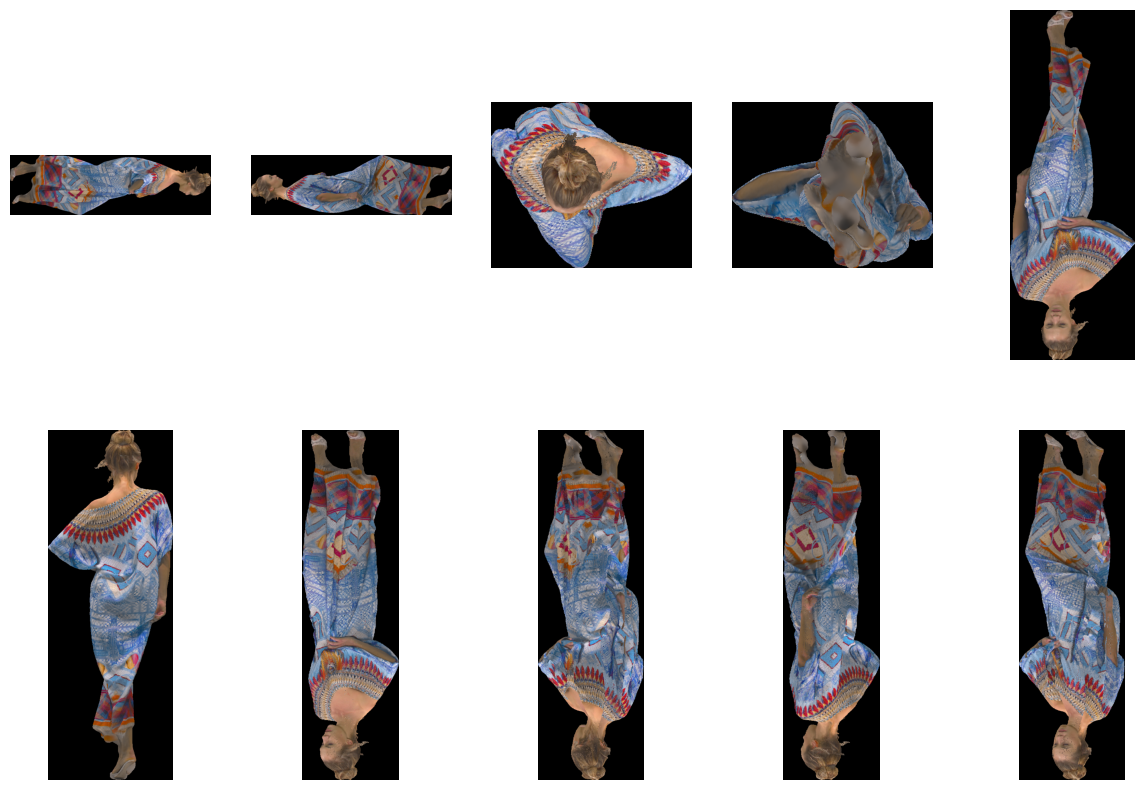

In [5]:
# Reading the PLY file
ply_path = "../pcd/longdress/longdress/Ply/longdress_vox10_1051.ply"
pcd = o3d.io.read_point_cloud(ply_path)

# Obtaining 2D projections
projections, mappings = get_2d_images_from_3d_pcd(pcd)

base_path = "../results/longdress_viewdep_vox10_{}.jpg"
save_projections_as_images(projections, base_path)

# Plotting function 
def plot_projections(projections, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(projections):
            ax.imshow(projections[i])
    plt.show()

# Call plotting function
plot_projections(projections, 2, 5)

Time taken for image 0: 6.219626188278198 seconds
Time taken for image 1: 5.775039196014404 seconds
Time taken for image 2: 4.966829776763916 seconds
Time taken for image 3: 4.596785068511963 seconds
Time taken for image 4: 5.156161069869995 seconds
Time taken for image 5: 5.388829708099365 seconds
Time taken for image 6: 5.225692272186279 seconds
Time taken for image 7: 5.19488787651062 seconds
Time taken for image 8: 5.218592166900635 seconds
Time taken for image 9: 5.427270412445068 seconds


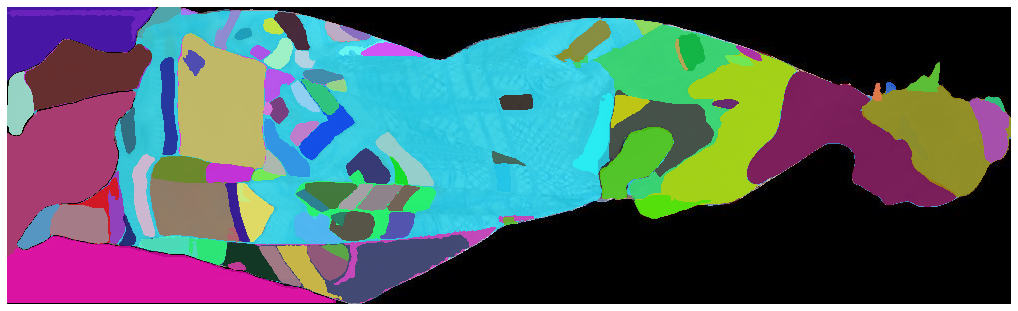

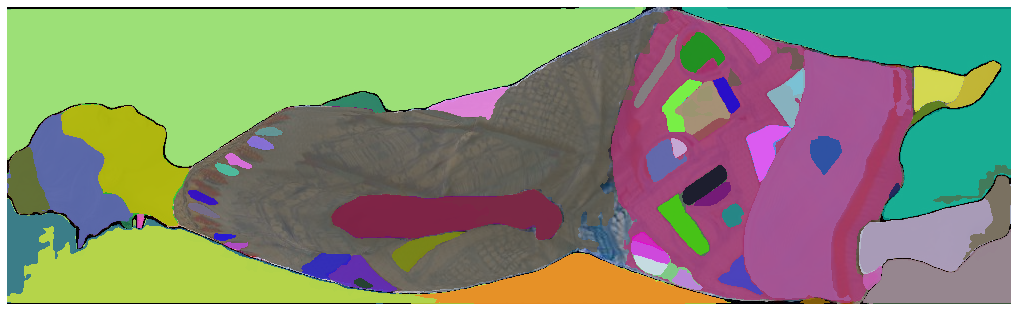

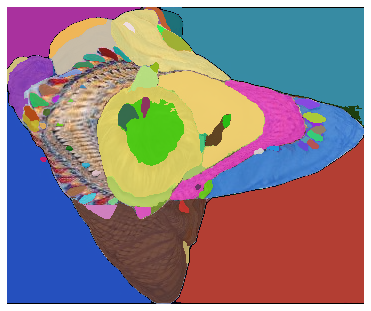

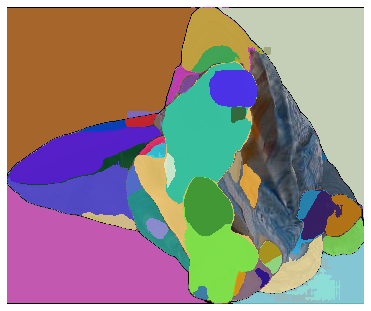

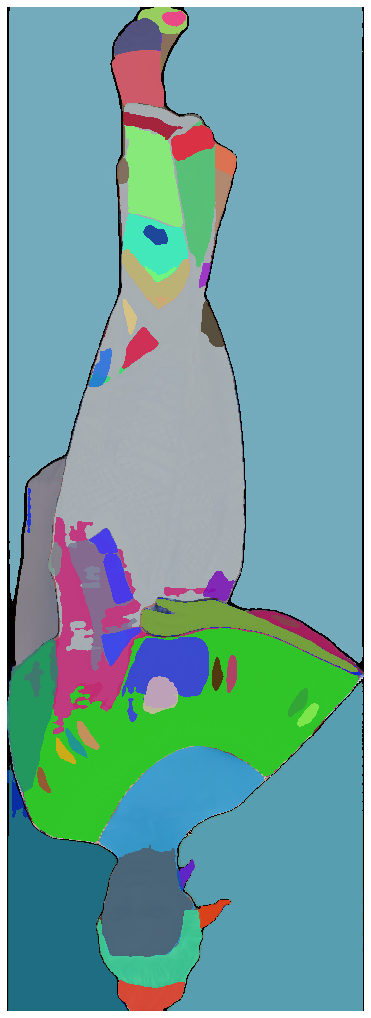

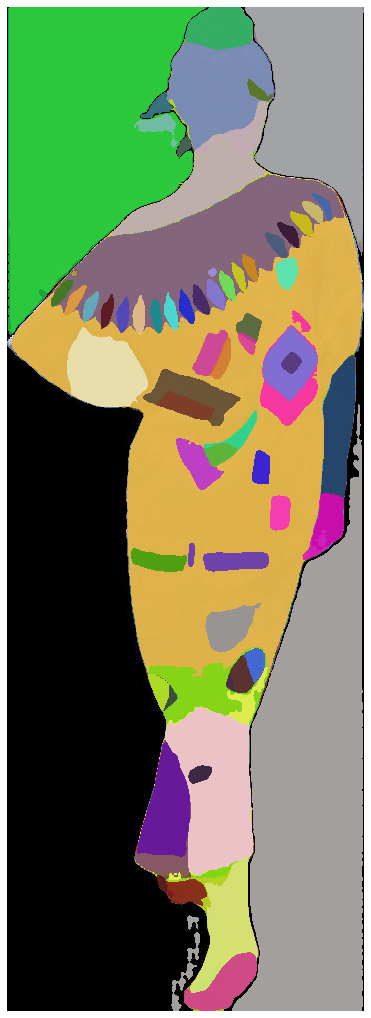

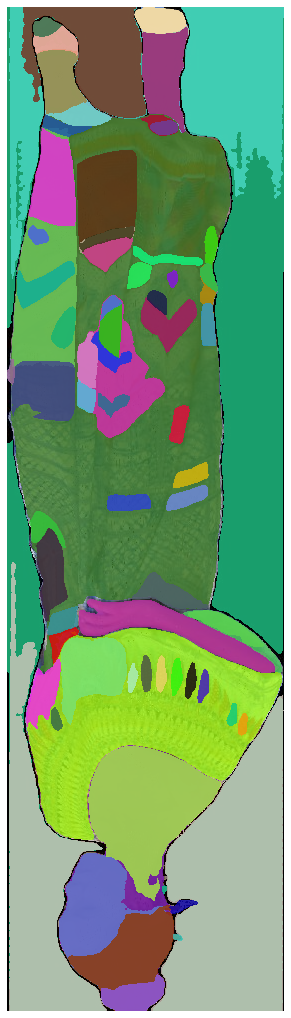

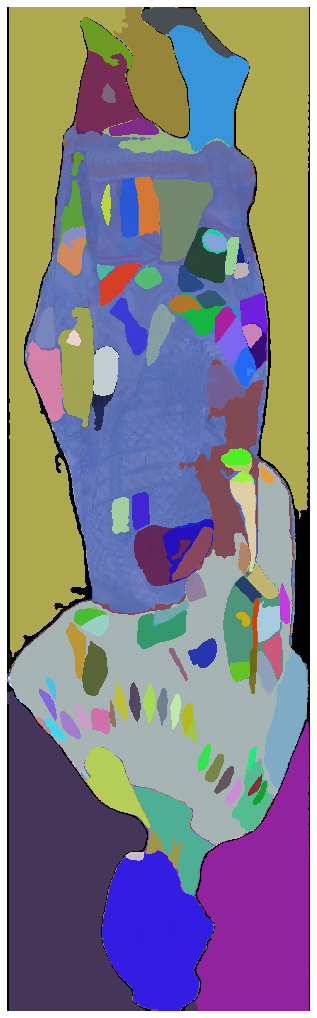

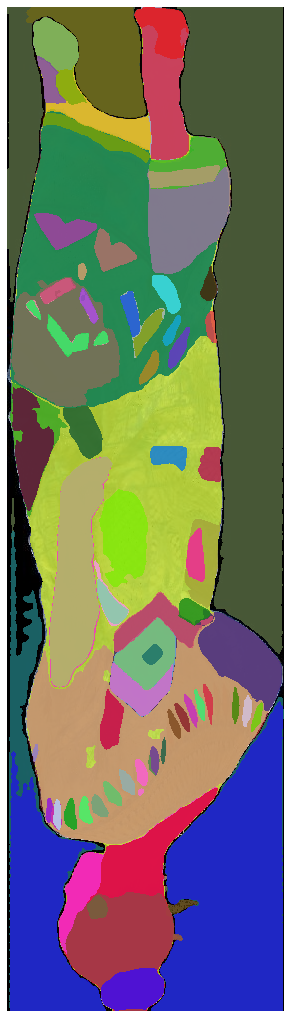

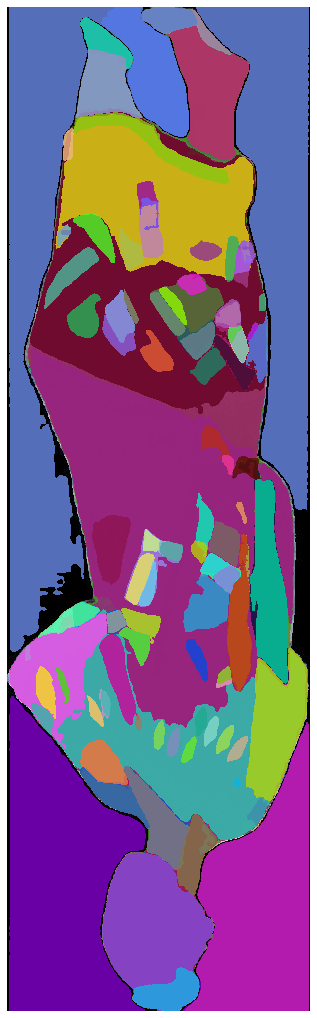

In [6]:
# Performing segmentation on the 2D projections
mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.75,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

results = []
segment2D_objects_list = [] # each item is a collection of segment2D objects from every projection

for i in range(10):
    # Construct the path for the current image
    image_path = f"../results/longdress_viewdep_vox10_{i}.jpg"
    
    # Read the image from the path
    image_bgr = cv2.imread(image_path)
    
    # Check if the image was read correctly
    if image_bgr is not None:
        # Convert the image to RGB
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Generate the mask using the SAM model
        t0 = time.time()
        result = mask_generator_2.generate(image_rgb)
        t1 = time.time()
        print(f"Time taken for image {i}: {t1 - t0} seconds")
        results.append(result)

        # Create the segment2D_objects, SORT in descending area, then append to segment2D_objects_list
        segment_objects = [
            Segment2D(
                area=segment['area'],
                bbox=segment['bbox'],
                crop_box=segment['crop_box'],
                point_coords=segment['point_coords'],
                predicted_iou=segment['predicted_iou'],
                stability_score=segment['stability_score'],
                segmentation=segment['segmentation']
            )
            for segment in result
        ]

        # Sort the segment_objects by area in descending order
        sorted_segment_objects = sorted(segment_objects, key=lambda segment: segment.area, reverse=True)
        
        # Append the sorted list to segment2D_objects_list
        segment2D_objects_list.append(sorted_segment_objects)

        # Desired output size - use the original image dimensions
        output_height, output_width, _ = image_rgb.shape
        dpi = 72
        
        figsize_width = output_width / dpi
        figsize_height = output_height / dpi
        
        fig = plt.figure(figsize=(figsize_width, figsize_height), dpi=dpi)
        fig.add_axes([0,0,1,1])
        
        plt.imshow(image_rgb)
        color_mask = sam_masks(result)
        plt.axis('off')
        plt.savefig(f"../results/longdress_vox10_{i}_segmented.jpg")

    else:
        print(f"Image at path {image_path} could not be read.")

In [7]:
# After generarting SAM segmented images, clear result directories
base_dir = "../results"  # Adjust this base directory as needed
folders_to_clear = ["final_subclouds",  "isolated_segments", "merged_segments"]

for folder in folders_to_clear:
    folder_path = os.path.join(base_dir, folder)
    clear_directory_contents(folder_path)
    print(f"{folder_path} has been cleared")

../results\final_subclouds has been cleared
../results\isolated_segments has been cleared
../results\merged_segments has been cleared


In [8]:
# Reconstructing point clouds containing only the isolated segments (no longer on the original point cloud for comparison)
isolated_segments_dir = "../results/isolated_segments"
for i, projection in enumerate(segment2D_objects_list):
    mapping = mappings[i]
    for j, segment2D in enumerate(projection):
        segmentation_area = segment2D.area
        if segmentation_area < 2500:
            continue
        segmentation_mask = segment2D.segmentation
        segment_cloud = reconstruct_segment_original(segmentation_mask, mapping, pcd)
        
        if segment_cloud.is_empty():  # Check if the segment cloud is empty
            # print(f"Skipping empty point cloud for Segment2D_{i}_{j}.")
            continue  # Skip saving this point cloud
                    
        isolated_segment_path = os.path.join(isolated_segments_dir, f"longdress_vox10_isolated_segment_{i}_{j}.ply")
        
        o3d.io.write_point_cloud(isolated_segment_path, segment_cloud)
        # print(f"Isolated Segment2D_{i}_{j} has been saved to path: {isolated_segment_path}")

In [9]:
# Define a base path for segment files
segment_cloud_base_path = "../results/isolated_segments/longdress_vox10_isolated_segment_{}_{}.ply"

# Generate segment pairs, parameters: (n_projections, max_segments_per_proj, segment_cloud_base_path)
segment_pairs = generate_segment_pairs(10, 10, segment_cloud_base_path)

# Initialize the list to store results
overlap_results = []
threshold = 0

# Process each pair to calculate overlap ratio and correspondences
for i, (seg1, seg2) in enumerate(segment_pairs):
    path1 = segment_cloud_base_path.format(seg1[0], seg1[1])
    path2 = segment_cloud_base_path.format(seg2[0], seg2[1])

    # Load point clouds
    cloud1 = o3d.io.read_point_cloud(path1)
    cloud2 = o3d.io.read_point_cloud(path2)
    
    # Convert Open3D point clouds to NumPy arrays
    points1 = np.asarray(cloud1.points)
    points2 = np.asarray(cloud2.points)
    
    # Calculate overlap ratio and correspondences
    overlap_ratio, correspondences = find_correspondences(points1, points2, threshold)
    
    # Append results for non-zero overlaps
    if overlap_ratio > 0.0:
        overlap_results.append({
            "SegmentPair": f"{seg1} with {seg2}",
            "OverlapRatio": overlap_ratio,
            "NumCorrespondences": len(correspondences)
        })

# Convert results to a Pandas DataFrame
df = pd.DataFrame(overlap_results)

# Sort by OverlapRatio in decreasing order
df_sorted = df.sort_values(by='OverlapRatio', ascending=False)

# Save the sorted DataFrame to CSV
csv_path = "../results/longdress_vox10_segment_overlap_results.csv"
df_sorted.to_csv(csv_path, index=False)

print(f"Overlap results saved to {csv_path}")

Overlap results saved to ../results/longdress_vox10_segment_overlap_results.csv


In [10]:
# Step 1: Create a graph of segment overlaps
G = nx.Graph()

# overlap / correspondence threshold to consider seg1 and seg2 as connected on the graph
overlap_threshold = 0.2
correspondence_threshold = 100

for result in overlap_results:
    seg1, seg2 = result["SegmentPair"].split(" with ")
    overlap_ratio = result["OverlapRatio"]
    num_correspondences = result["NumCorrespondences"]

    # Check number of correspondences to avoid odd tiny segment
    if num_correspondences < correspondence_threshold:
        continue
    
    # Check if the overlap ratio is above the threshold
    # if (overlap_ratio > overlap_threshold) or (num_correspondences > correspondence_threshold):
    if overlap_ratio > overlap_threshold:
        # Only add an edge if the overlap ratio exceeds the threshold
        G.add_edge(seg1, seg2)
        
# Step 2: Find connected components - each one represents a set of segments to be merged
connected_components = list(nx.connected_components(G))
print(f"number of connected components components: {len(connected_components)}")
print(f"connected components are: {connected_components}")

# Step 3: Merge segments in each connected component
merged_point_clouds = []
for component in connected_components:
    merged_points = []
    merged_colors = []
    for segment_id in component:
        path = segment_cloud_base_path.format(*eval(segment_id))
        pcd = o3d.io.read_point_cloud(path)
        merged_points.extend(np.asarray(pcd.points))
        merged_colors.extend(np.asarray(pcd.colors))
    
    # Create a new point cloud for the merged segment
    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(merged_points)
    merged_pcd.colors = o3d.utility.Vector3dVector(merged_colors)
    merged_point_clouds.append(merged_pcd)

# Step 4: Save the merged segments
for i, pcd in enumerate(merged_point_clouds):

    # converting write coordinate type from double to float (to be same as original ply file, such that VPCC can compress it)
    points = np.asarray(pcd.points)
    dtype = o3d.core.float32
    p_tensor = o3d.core.Tensor(points, dtype=dtype)
    pcd_float32 = o3d.t.geometry.PointCloud(p_tensor)

    # Ensure that colors are in the range [0, 255] and of type uint8
    colors = np.asarray(pcd.colors)
    if np.max(colors) <= 1.0:
        # If colors are in [0, 1], scale to [0, 255]
        colors = (colors * 255).astype(np.uint8)
    else:
        # If colors are already in [0, 255], just convert to uint8
        colors = colors.astype(np.uint8)
    colors_tensor = o3d.core.Tensor.from_numpy(colors) 
    colors_tensor = o3d.core.Tensor(colors, dtype=o3d.core.uint8)

    # Create a new tensor point cloud and set its points and colors
    pcd_tensor = o3d.t.geometry.PointCloud(p_tensor)
    pcd_tensor.point.colors = colors_tensor

    save_path = f"../results/merged_segments/longdress_vox10_merged_segment_{i}.ply"
    # Use the new tensor API to write the point cloud with colors
    o3d.t.io.write_point_cloud(save_path, pcd_tensor, write_ascii=True)


# Remaining segments
segments_directory = "../results/isolated_segments"

# List all files in the directory
segment_files = os.listdir(segments_directory)

# Process files to extract tuple information
all_segments = set()
for filename in segment_files:
    if filename.endswith('.ply'):  # Check if the filename ends with '.ply'
        # Remove the '.ply' extension and then split
        parts = filename.replace('.ply', '').split('_')
        try:
            x_part = parts[-2]  # This would be the 'X' part in 'segment_X_Y'
            y_part = parts[-1].split('.')[0]  # This would be the 'Y' part in 'segment_X_Y', removing '.ply'
            segment_tuple = f"({x_part}, {y_part})"
            all_segments.add(segment_tuple)
        except IndexError:
            # Handle the case where the filename does not match the expected format
            print(f"Filename {filename} does not match expected format and was skipped.")
    

# Get all segments involved in overlaps
overlapping_segments = set(G.nodes)
# print(f"overlapping_segments: {overlapping_segments}")

# Determine isolated segments that were not involved in any overlap
isolated_segments = all_segments - overlapping_segments
# print(f"remaining isolated_segments: {isolated_segments}")

# Base path template that includes placeholders for x and y values
segment_cloud_base_path = "../results/isolated_segments/longdress_vox10_isolated_segment_{}_{}.ply"

# Merge all isolated segments into a single point cloud
# isolated_segments is a list of tuples in string format like ['(2, 5)', '(1, 1)']
remaining_points = []
remaining_colors = []
for seg_id in isolated_segments:
    # Strip parentheses and split by comma
    x, y = seg_id.strip('()').split(', ')
    # Use x and y to complete the file path
    seg_path = segment_cloud_base_path.format(x, y)
    # print(f"seg_path is: {seg_path}")
    if os.path.exists(seg_path):
        segment_pcd = o3d.io.read_point_cloud(seg_path)
        remaining_points.extend(np.asarray(segment_pcd.points))
        remaining_colors.extend(np.asarray(segment_pcd.colors))

# Create the remaining_segments point cloud
remaining_pcd = o3d.geometry.PointCloud()
remaining_pcd.points = o3d.utility.Vector3dVector(remaining_points)
remaining_pcd.colors = o3d.utility.Vector3dVector(remaining_colors)

# Save the remaining_segments point cloud
remaining_pcd_path = os.path.join("../results/merged_segments/remaining_segments.ply")
o3d.io.write_point_cloud(remaining_pcd_path, remaining_pcd)

print(f"Merged remaining isolated segments into '{remaining_pcd_path}'")


number of connected components components: 2
connected components are: [{'(4, 7)', '(8, 6)', '(2, 5)', '(2, 8)', '(6, 7)', '(0, 5)', '(6, 8)', '(9, 9)', '(0, 2)', '(4, 9)', '(8, 7)', '(7, 6)', '(1, 8)', '(6, 5)', '(7, 8)'}, {'(5, 5)', '(7, 9)', '(9, 4)', '(9, 2)', '(8, 9)', '(8, 2)', '(5, 1)', '(4, 6)', '(0, 8)', '(2, 9)', '(8, 5)', '(8, 8)', '(4, 1)', '(9, 7)', '(9, 1)', '(0, 7)', '(1, 3)', '(3, 9)', '(6, 6)', '(4, 4)', '(3, 3)', '(0, 9)', '(2, 6)', '(3, 7)', '(0, 3)', '(4, 2)', '(1, 9)', '(1, 7)', '(1, 2)', '(7, 2)', '(5, 6)', '(6, 3)', '(9, 6)', '(0, 6)', '(2, 7)', '(3, 8)', '(6, 1)', '(5, 9)', '(7, 7)', '(7, 3)'}]
Merged remaining isolated segments into '../results/merged_segments/remaining_segments.ply'


In [11]:
# Visualizing merged clouds
for i, pcd in enumerate(merged_point_clouds):
    o3d.visualization.draw_geometries([pcd])

In [12]:
# Process point clouds
merged_segments_base_path = "../results/merged_segments"
final_subclouds_base_path = "../results/final_subclouds"
merged_pcd_files = sorted([f for f in os.listdir(merged_segments_base_path) if f.endswith('.ply')])

# Load all point clouds
pcds = {fname: o3d.io.read_point_cloud(os.path.join(merged_segments_base_path, fname)) for fname in merged_pcd_files}

# Deduplicate each pair of point clouds
for fname1, fname2 in combinations(pcds.keys(), 2):
    pcd1 = pcds[fname1]
    pcd2 = pcds[fname2]
    # Remove duplicates from pcd2 based on pcd1
    pcds[fname2] = remove_duplicates_from_second_pcd(pcd1, pcd2)

count = 0
# Save all deduplicated point clouds
for fname, pcd in pcds.items():

    # converting write coordinate type from double to float (to be same as original ply file, such that VPCC can compress it)
    points = np.asarray(pcd.points)
    dtype = o3d.core.float32
    p_tensor = o3d.core.Tensor(points, dtype=dtype)
    pcd_float32 = o3d.t.geometry.PointCloud(p_tensor)

    # Ensure that colors are in the range [0, 255] and of type uint8
    colors = np.asarray(pcd.colors)
    if np.max(colors) <= 1.0:
        # If colors are in [0, 1], scale to [0, 255]
        colors = (colors * 255).astype(np.uint8)
    else:
        # If colors are already in [0, 255], just convert to uint8
        colors = colors.astype(np.uint8)
    colors_tensor = o3d.core.Tensor.from_numpy(colors) 
    colors_tensor = o3d.core.Tensor(colors, dtype=o3d.core.uint8)

    # Create a new tensor point cloud and set its points and colors
    pcd_tensor = o3d.t.geometry.PointCloud(p_tensor)
    pcd_tensor.point.colors = colors_tensor

    final_save_path = f"../results/final_subclouds/longdress_vox10_final_subcloud_{count}.ply"
    count += 1
    # Use the new tensor API to write the point cloud with colors
    o3d.t.io.write_point_cloud(final_save_path, pcd_tensor, write_ascii=True)
    print(f"saved to: {final_save_path}")


saved to: ../results/final_subclouds/longdress_vox10_final_subcloud_0.ply
saved to: ../results/final_subclouds/longdress_vox10_final_subcloud_1.ply
saved to: ../results/final_subclouds/longdress_vox10_final_subcloud_2.ply
